In [22]:
# Clear all variables
%reset -f

# Do the imports
import matplotlib
from matplotlib import pyplot as plt
import ipywidgets
from src.beads import *

# Configure matlotlib under the `notebook` setting and initialize figure size
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (9,7)

# Helper functions

def new_fig():
    return plt.subplots(1, 1)
def new_ax():
    fig, ax = new_fig()
    return ax


def connect(fig, fn):
    return fig.canvas.mpl_connect('button_press_event', fn)

canvas = Canvas(-20,20,100)

# Audio source separation with magnitude priors: the BEADS model 

## Antoine Liutkus$^1$, Christian Rohlfing$^2$, Antoine Deleforge$^3$

$^1$ Zenith team, Inria, University of Montpellier, France<p>
$^2$ RWTH, Aachen University, Germany<p>
$^3$ Inria Rennes - Bretagne Atlantique, France<p>

<div class="inline-block">
    <img src="figures/zenith.jpg" style="height:3em; margin-top:5em">
</div>
<div class="inline-block">
    <img src ="figures/inria.png" style="height:3em">
</div>
<div class="inline-block">
    <img src="figures/rwth.svg" style="height:3em">
</div>
<div class="inline-block">
    <img src="figures/anr.png" style="height:3em">
</div>
</div>


<IPython.core.display.Javascript object>


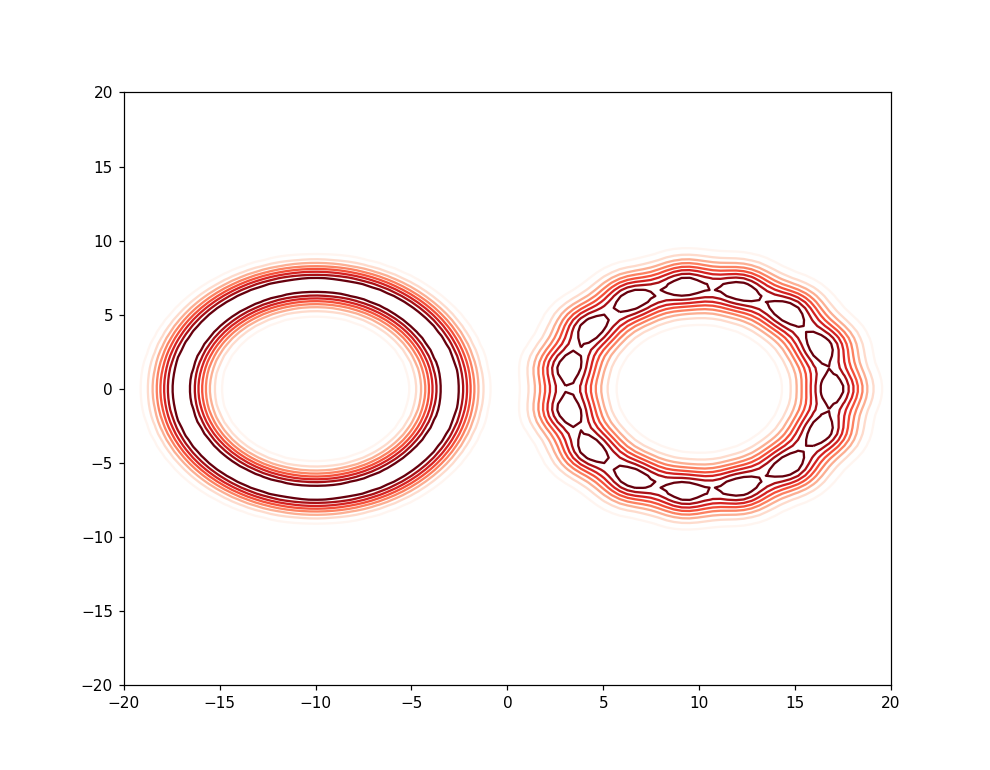

In [23]:
a = Donut(-10,7,2)
b = Beads(10,7,3,15)
ax = new_ax()
a.plot(canvas, ax, colors='Reds', nlines=10)
b.plot(canvas, ax, colors='Reds', nlines=10)

In [24]:
bs = [10, 4, 2]
sigmas = [3,4,0.2]
cs = [15, 15, 15]
colors = ['Greens', 'Blues', 'Reds']

sources = [Beads(0,b,sigma,c) for (b,sigma,c) in zip(bs,sigmas,cs)]

<IPython.core.display.Javascript object>


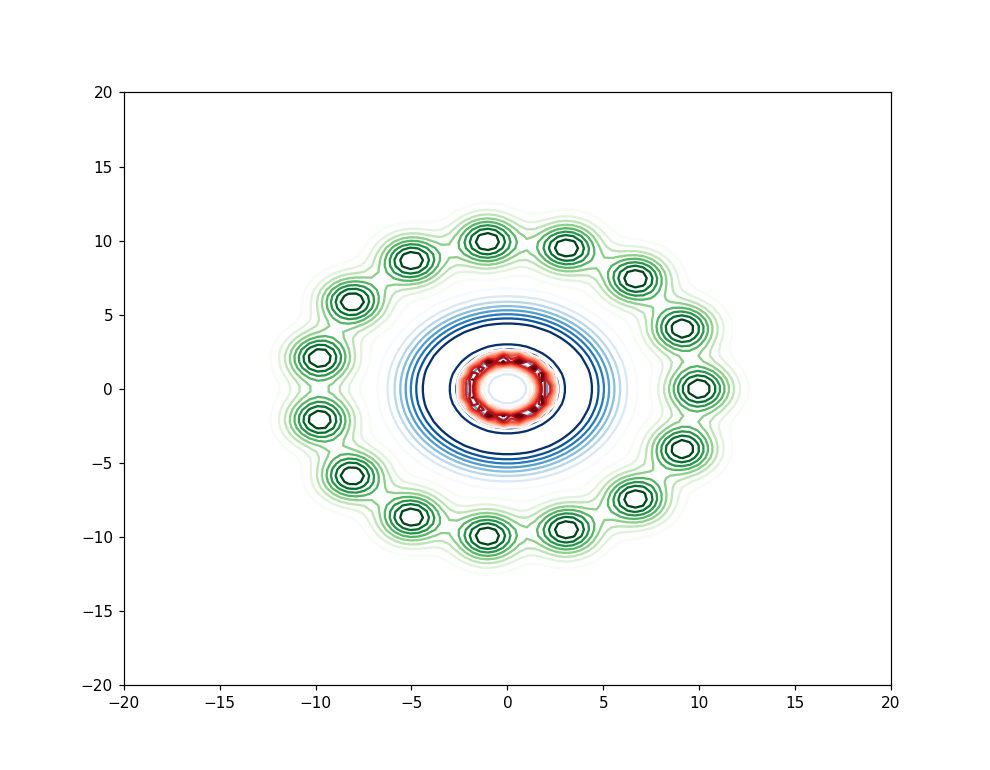

In [25]:
ax = new_ax()
for (s, color) in zip(sources, colors):
    s.plot(canvas, ax, color, nlines=10)

<IPython.core.display.Javascript object>


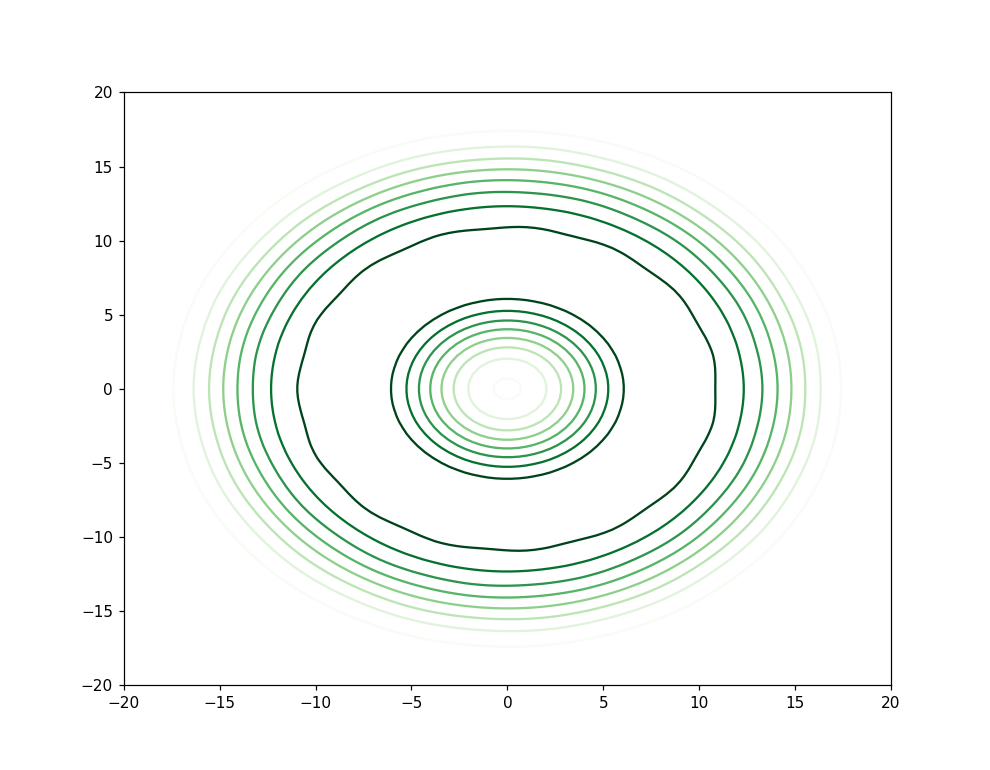

In [28]:
mix = GMM.product(sources)
mix.plot(canvas, colors = "Greens", nlines=10)

<IPython.core.display.Javascript object>


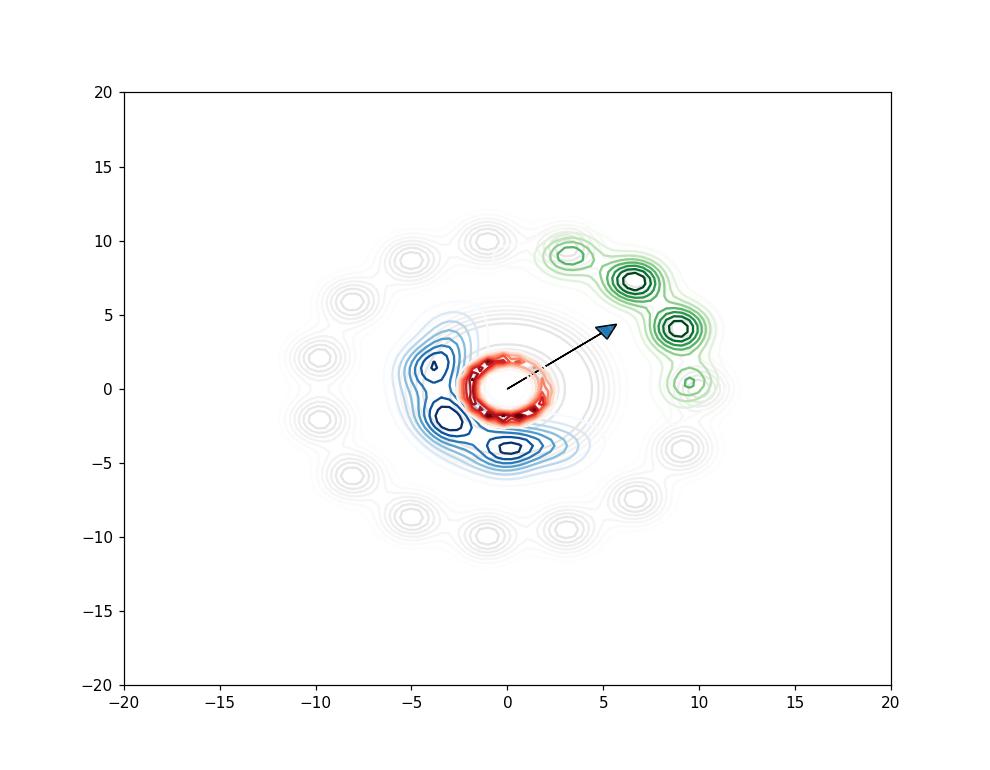

In [27]:
fig, ax = new_fig()

for (s, color) in zip(sources, colors):
    s.plot(canvas, ax, color, nlines=10)
   
def click_event(sources, mix, ax, plot_prior=True):
    def onclick(event):
        x = event.xdata+1j*event.ydata

        sources_post = [s.post(mix,x) for s in sources]
        
        ax.clear() 
        for (s, spost, color) in zip(sources, sources_post, colors):
            if plot_prior:
                s.plot(canvas, ax, "Greys", nlines=10, alpha=0.1)
            spost.plot(canvas, ax, color, nlines=10)
        ax.arrow(0, 0, np.real(x), np.imag(x), head_width=1, head_length=1)
    return onclick

cid = connect(fig, click_event(sources, mix, ax, plot_prior=True))

<IPython.core.display.Javascript object>


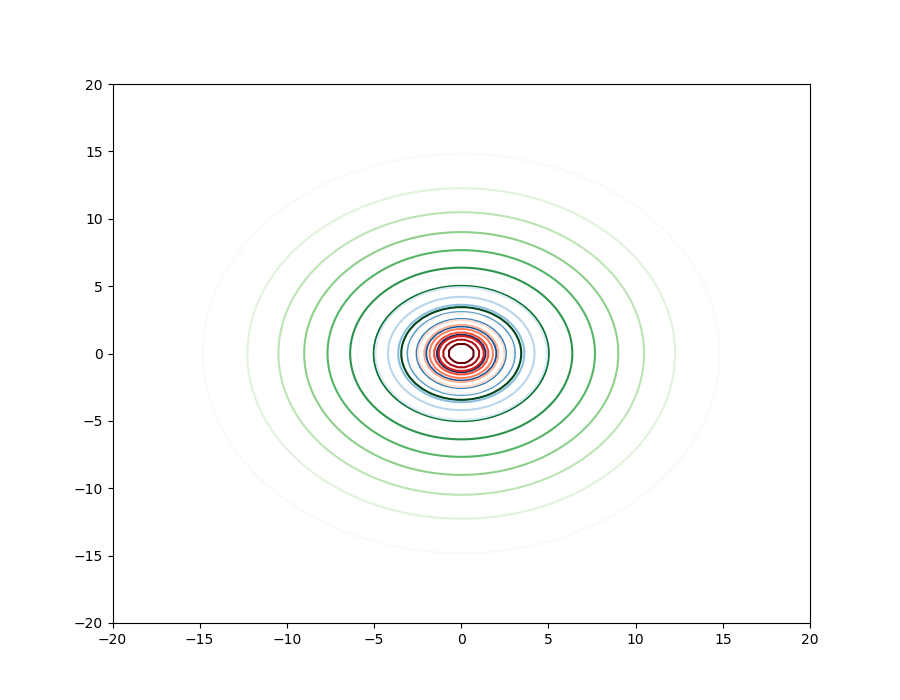

In [40]:
sources_LGM = [Beads(0,0, b**2,1) for b in bs]

ax = new_ax()
for (s, color) in zip(sources_LGM, colors):
    s.plot(canvas, ax, color, nlines=10)

<IPython.core.display.Javascript object>


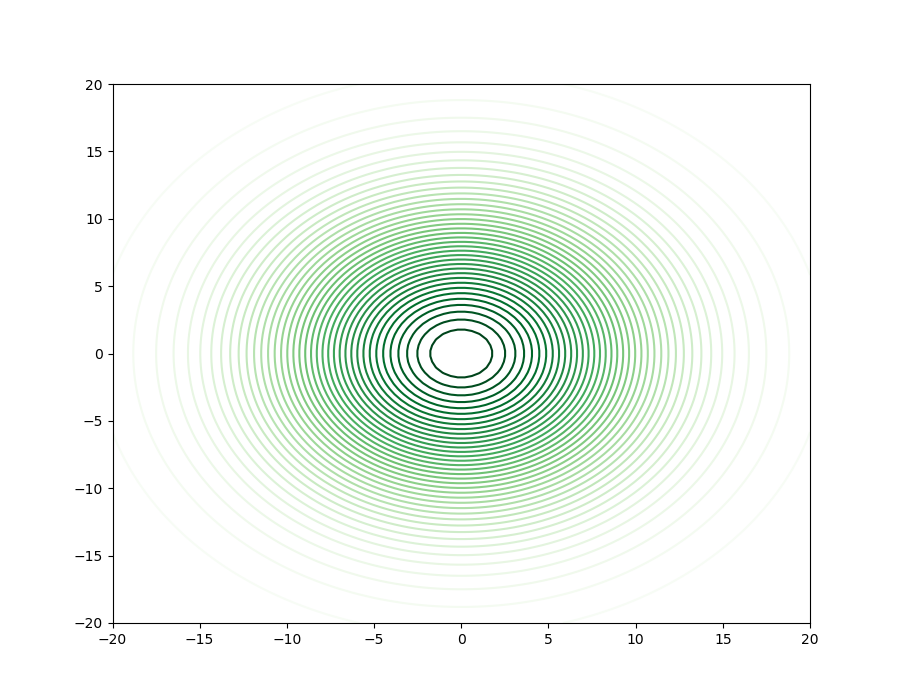

In [41]:
mix_LGM = GMM.product(sources_LGM)
mix_LGM.plot(canvas, colors = "Greens", nlines=40)

<IPython.core.display.Javascript object>


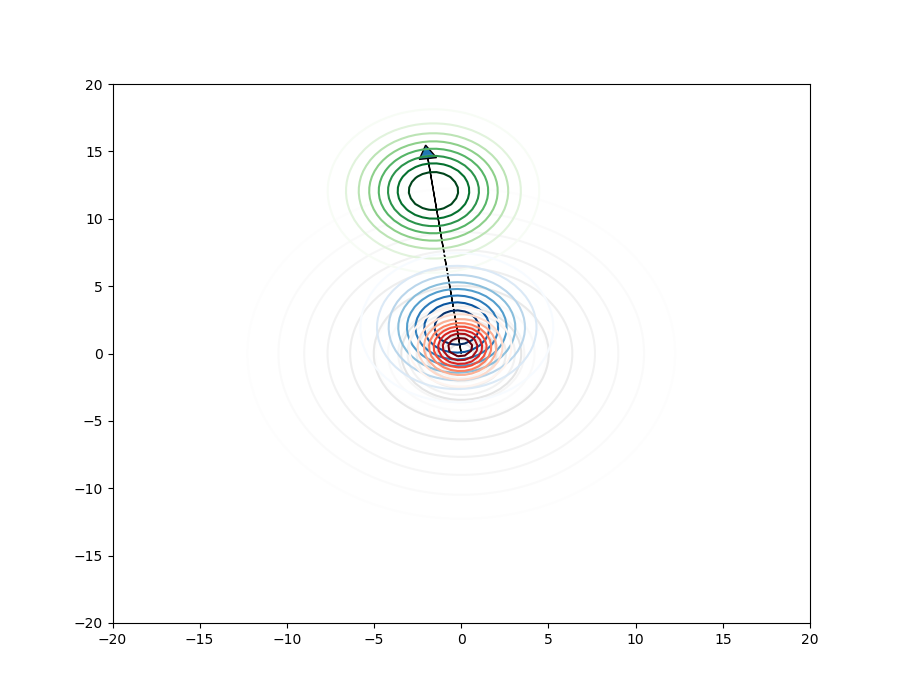

In [42]:
fig, ax = new_fig()

for (s, color) in zip(sources_LGM, colors):
    s.plot(canvas, ax, color, nlines=10)

def onclick(event):
    x = event.xdata+1j*event.ydata

    sources_LGM_post = [s.post(mix_LGM,x) for s in sources_LGM]

    ax.clear()
    for (s, spost, color) in zip(sources_LGM, sources_LGM_post, colors):
        s.plot(canvas, ax, "Greys", nlines=10, alpha=0.1)
        spost.plot(canvas, ax, color, nlines=10)
    ax.arrow(0, 0, np.real(x), np.imag(x), head_width=1, head_length=1)
   
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)